In [1]:
import sys
import os
sys.path.append('lib.py')
from lib import *
import random
import cv2
from tqdm import tqdm

In [2]:
pydicom_folder = './test_2/'
source_folder = './test_1/'
matched_output_folder = './out_source_matched/'
source_mask_output_folder = './out_mask_source/'
target_mask_output_folder = './out_mask_target/'

REPLACE_BG_FLAG = True
USE_MASK_FLAG = True

if not os.path.exists(matched_output_folder):
    os.mkdir(matched_output_folder)
if not os.path.exists(source_mask_output_folder):
    os.mkdir(source_mask_output_folder)
if not os.path.exists(target_mask_output_folder):
    os.mkdir(target_mask_output_folder)

### 随机选取一个data查看

In [3]:
pydicom_files = []
source_files = []
for root, dirs, files in os.walk(pydicom_folder, topdown=False):
    for name in files:
        path = os.path.join(root, name)
        # print(path)
        pydicom_files.append(path)

In [4]:
file_path = random.choice(pydicom_files)
file_name = file_path.split('/')[-1]
print(file_name)
data = readPydicom(file_path)

0000008B


max=255, min=0


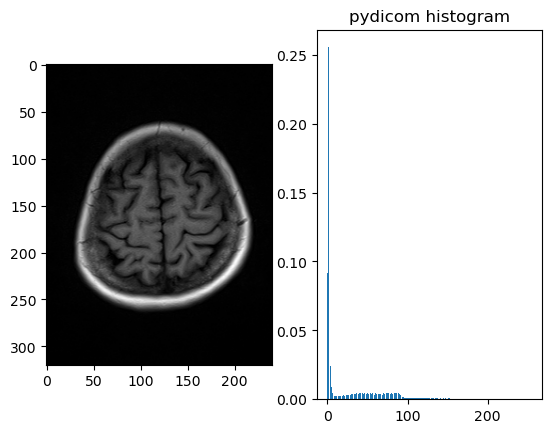

In [5]:
data_img = Image.fromarray(data)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(data_img, cmap="gray")
max_pixel,min_pixel = np.max(data),np.min(data)
print(f"max={max_pixel}, min={min_pixel}")
hist_dict = arrayToHist(data, max_pixel-min_pixel+1)
plt.subplot(1,2,2)
drawHist(hist_dict, "pydicom histogram")
plt.show()

# data_img.save("./test_2/" + file_name + ".png")

### step1: 获取 target直方图

In [6]:
pydicom_files = []
for root, dirs, files in os.walk(pydicom_folder, topdown=False):
    for name in files:
        path = os.path.join(root, name)
        # print(path)
        pydicom_files.append(path)

sum = 0
target_hist = {}
for k in range(255):
    target_hist[k] = 0
    
print(f"found {len(pydicom_files)} files in target folder.")

with tqdm(total=len(pydicom_files)) as pbar:
    
    # 对所有图片的直方图信息进行统计
    for pydicom_f in pydicom_files:
        
        # print(pydicom_f)
        pbar.update(1)
        
        file_name = pydicom_f.split('/')[-1]
        if(file_name.startswith('.')):
            continue
        data = readPydicom(pydicom_f)
        
        # 获取当前file的mask
        mask = getArrayMask(data, save=target_mask_output_folder + file_name + '.png')
        max_pixel,min_pixel = np.max(data),np.min(data)
        
        if (len(data.shape) != 2):
            print("shape error")
            break
        h, w = data.shape
        for i in range(h):
            for j in range(w):
                # 略过非mask区域，只统计区域内
                if mask[i][j] == 0:
                    continue
                if target_hist.get(data[i][j]) is None:
                    target_hist[data[i][j]] = 0
                target_hist[data[i][j]] += 1
                sum += 1
            
# 对直方图进行normalize
print(f'total pixel in target images={sum}')
for key in target_hist.keys():
    target_hist[key] = float(target_hist[key]) / sum

found 4 files in target folder.


100%|██████████| 4/4 [00:05<00:00,  1.25s/it]

total pixel in target images=103237


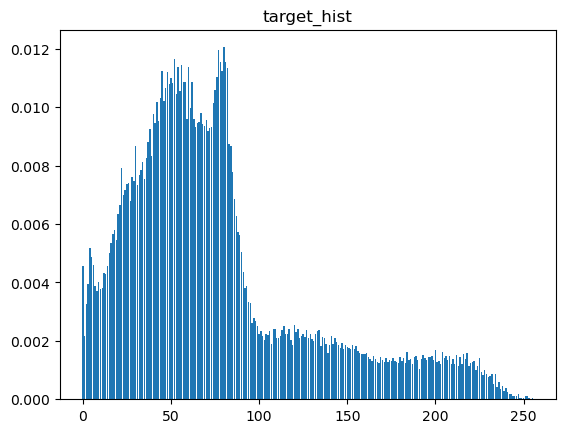

In [7]:
drawHist(target_hist, "target_hist")

# step2: 对folder内所有图片进行处理

In [8]:
source_files = []
for root, dirs, files in os.walk(source_folder, topdown=False):
    for name in files:
        path = os.path.join(root, name)
        source_files.append(path)
        
print(f'found {len(source_files)} files in source folder')

with tqdm(total=len(source_files)) as pbar:
    
    for source_f in source_files:
        
        file_name = source_f.split('/')[-1]
        # print(file_name)
        
        # 获取mask
        mask = getMask(path=source_f, save=source_mask_output_folder + file_name)
        
        # 读取灰度图
        im_s = cv2.imread(source_f, cv2.IMREAD_GRAYSCALE)
        im_s_arr = np.array(im_s)
        
        # 进行balance
        hist_s_in_mask = arrayToHist(im_s_arr, 256, use_mask=USE_MASK_FLAG, mask=mask)
        im_s_arr_balanced = equalization(im_s_arr, hist_s_in_mask, 256, use_mask=USE_MASK_FLAG, mask=mask,
                                     replace_bg=REPLACE_BG_FLAG)
        
        # 将source balanced 按照 target 进行match
        im_s_balanced_matched_arr = histMatch(im_s_arr_balanced, target_hist, use_mask=USE_MASK_FLAG,
                                          mask=mask, replace_bg=REPLACE_BG_FLAG)
        
        #保存match后的图片
        im_out_balanced_matched = Image.fromarray(im_s_balanced_matched_arr, mode='L')
        im_out_balanced_matched.save(matched_output_folder + file_name)
    
        pbar.update(1)
    

found 3 files in source folder


100%|██████████| 3/3 [00:11<00:00,  3.67s/it]
